# Perkenalan

Nama : Mehdi Mursalat Ismail

Batch : FTDS-020-RMT

Dataset : twitter_training.csv

Objective : Predict sentiment of tweet of nvidia.

# Import Libraries

In [207]:
# Import Libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import re 
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

# Data Loading

In [208]:
# Data Loading

data=pd.read_csv('twitter_training.csv', sep=',', names=['tweet_id','entity','sentiment','tweet_content'])
data.head()

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [209]:
data.shape

(74682, 4)

In [210]:
data_eda = data.copy()

In [211]:
data_eda.isnull().sum()

tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [212]:
data_eda.entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [213]:
nvidia_tweet = data.loc[data['entity'] == 'Nvidia']

In [265]:
nvidia_tweet.to_csv('nvidia_tweets.csv')

# EDA

([<matplotlib.patches.Wedge at 0x1af48a2b9a0>,
 [Text(-1.0299688055345073, 0.38621789138492846, 'Negative'),
  Text(0.3979694160253483, -1.0254854186717837, 'Positive'),
  Text(0.9041127658094765, 0.6265621331522827, 'Neutral'),
  Text(0.1348712209498326, 1.091700395602888, 'Irrelevant')],
 [Text(-0.5618011666551858, 0.21066430439177916, '38.6%'),
  Text(0.21707422692291722, -0.559355682911882, '34.6%'),
  Text(0.4931524177142599, 0.3417611635376087, '22.9%'),
  Text(0.0735661205180905, 0.5954729430561205, '3.9%')])

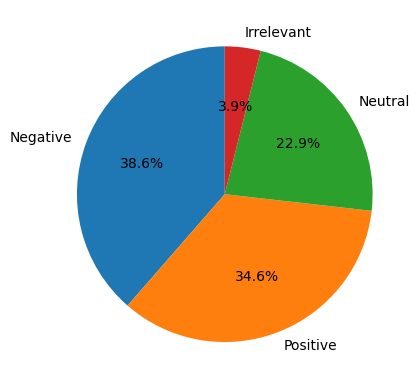

In [255]:
plt.pie(nvidia_tweet.sentiment.value_counts()
,labels=['Negative','Positive','Neutral','Irrelevant'],autopct='%1.1f%%',startangle=90)

In [215]:
nvidia_tweet.sentiment.value_counts()

Neutral       870
Positive      816
Negative      522
Irrelevant     90
Name: sentiment, dtype: int64

Insights:

There's more negative tweets about nvidia than positive tweets with 4% of difference

# Feature Engineering

## Handling Missing Value

Checking missing value on data

In [216]:
nvidia_tweet.isnull().sum()

tweet_id          0
entity            0
sentiment         0
tweet_content    27
dtype: int64

There's a small amount of missing value, so we can just drop the rows without worrying for data behavior to change

In [217]:
nvidia_tweet.dropna(subset=['tweet_content'], inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10132\176145617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_tweet.dropna(subset=['tweet_content'], inplace=True)


In [218]:
nvidia_tweet.isnull().sum()

tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64

In [219]:
nvidia_tweet.shape

(2271, 4)

In [220]:
nvidia_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 72384 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2271 non-null   int64 
 1   entity         2271 non-null   object
 2   sentiment      2271 non-null   object
 3   tweet_content  2271 non-null   object
dtypes: int64(1), object(3)
memory usage: 88.7+ KB


## Handling Duplicates

Checking Duplicate

In [221]:
nvidia_tweet.duplicated().sum()

73

In [222]:
nvidia_tweet.drop_duplicates(inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10132\2087017006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_tweet.drop_duplicates(inplace=True)


In [223]:
nvidia_tweet.shape

(2198, 4)

## Text Preprocessing

In [224]:
nvidia_tweet.head()

,tweet_id,entity,sentiment,tweet_content
72384,8801,Nvidia,Neutral,Interesting NVIDIA=ARM. nvidianews.nvidia.com/...
72385,8801,Nvidia,Neutral,Interesting NVIDIA = ARM. nvidianews.nvidia.co...
72387,8801,Nvidia,Neutral,Interesting NVIDIA=ARM. news.nvidia.com/news/n...
72388,8801,Nvidia,Neutral,Information Interesting for NVIDIA = via ARM. ...
72389,8801,Nvidia,Neutral,Interesting NVIDIA=ARM. nvidianews.nvidia.com/...


In [225]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

## Define X

In [226]:
X = nvidia_tweet['tweet_content'].apply(lambda p: clean_text(p))

In [227]:
X.head()

72384    interesting nvidia=arm . nvidianews .nvidia .c...
72385    interesting nvidia = arm . nvidianews .nvidia ...
72387    interesting nvidia=arm . news .nvidia .com/new...
72388    information interesting for nvidia = via arm ....
72389    interesting nvidia=arm . nvidianews .nvidia .c...
Name: tweet_content, dtype: object

max tweet_content len: 198


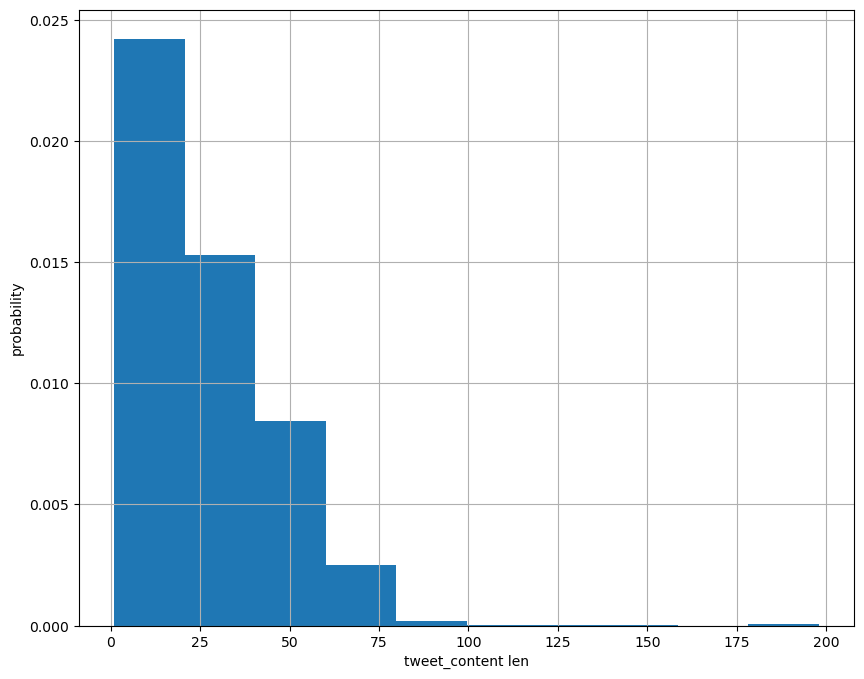

In [228]:
tweet_content_len = X.apply(lambda p: len(p.split(' ')))
max_tweet_content_len = tweet_content_len.max()
print('max tweet_content len: {0}'.format(max_tweet_content_len))
plt.figure(figsize = (10, 8))
plt.hist(tweet_content_len, density = True)
plt.xlabel('tweet_content len')
plt.ylabel('probability')
plt.grid()

In [229]:
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
english_stop_words = stopwords.words('english')

def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

## Define Y

In [230]:
y = nvidia_tweet['sentiment']

In [231]:
reviewtweet = reviews(X)
no_stop_words_tweet = remove_stop_words(reviewtweet)
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

Checking text preprocessing result

In [232]:
stemmed_reviews_tweet[20]

'nvidia alpha rtx 3080 pro derail websit glitch , error , lack suppli anith .com/nvidia-geforce…'

## Encoding

In [233]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)
X = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
X = pad_sequences(X, maxlen = 200)

In [234]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))

## Splitting between Train-Set, Val-Set, and Test-Set

In [235]:
# # Splitting between `X` and `y`

# X = data.drop('churn_risk_score', axis=1)
# y = data['churn_risk_score']

In [236]:
# Splitting between Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)

Train Size :  (1758, 200)
Test Size :  (440, 200)


# Model Definition

In [237]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 200))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

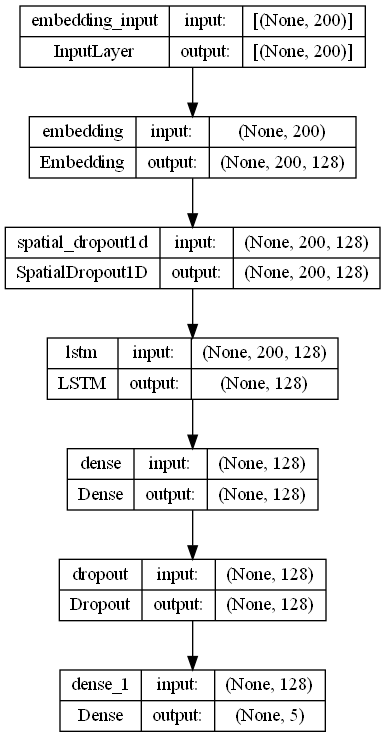

In [238]:
# Plot Layers

tf.keras.utils.plot_model(model_lstm, show_shapes=True)

##  Model Training

In [239]:
# Train the Model

history = model_lstm.fit(
        X_train,
        y_train,
        validation_data=(X_test,y_test) , 
        epochs = 30,
        batch_size = 512
)

Epoch 1/30
4/4 [==============================] - 23s 2s/step - loss: 1.5972 - accuracy: 0.3413 - val_loss: 1.5564 - val_accuracy: 0.4159
Epoch 2/30
4/4 [==============================] - 8s 2s/step - loss: 1.5268 - accuracy: 0.4164 - val_loss: 1.3761 - val_accuracy: 0.4091
Epoch 3/30
4/4 [==============================] - 7s 2s/step - loss: 1.3280 - accuracy: 0.3965 - val_loss: 1.2105 - val_accuracy: 0.4659
Epoch 4/30
4/4 [==============================] - 7s 2s/step - loss: 1.2211 - accuracy: 0.4334 - val_loss: 1.1709 - val_accuracy: 0.4750
Epoch 5/30
4/4 [==============================] - 7s 2s/step - loss: 1.2003 - accuracy: 0.4482 - val_loss: 1.1260 - val_accuracy: 0.5318
Epoch 6/30
4/4 [==============================] - 7s 2s/step - loss: 1.1386 - accuracy: 0.5233 - val_loss: 1.0923 - val_accuracy: 0.5386
Epoch 7/30
4/4 [==============================] - 7s 2s/step - loss: 1.0815 - accuracy: 0.5506 - val_loss: 1.0510 - val_accuracy: 0.5477
Epoch 8/30
4/4 [========================

## Model Improvement

In [240]:
history2 = model_lstm.fit(
        X_train,
        y_train,
        validation_data=(X_test,y_test) , 
        epochs = 50,
        batch_size = 512
)

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 0.0472 - accuracy: 0.9818 - val_loss: 0.1683 - val_accuracy: 0.9386
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 0.0486 - accuracy: 0.9829 - val_loss: 0.1505 - val_accuracy: 0.9409
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: 0.0502 - accuracy: 0.9784 - val_loss: 0.1670 - val_accuracy: 0.9432
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 0.0426 - accuracy: 0.9841 - val_loss: 0.1728 - val_accuracy: 0.9386
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.0447 - accuracy: 0.9841 - val_loss: 0.1574 - val_accuracy: 0.9364
Epoch 6/50
4/4 [==============================] - 9s 2s/step - loss: 0.0457 - accuracy: 0.9824 - val_loss: 0.1515 - val_accuracy: 0.9386
Epoch 7/50
4/4 [==============================] - 11s 2s/step - loss: 0.0397 - accuracy: 0.9852 - val_loss: 0.1451 - val_accuracy: 0.9386
Epoch 8/50
4/4 [========================

## Model Evaluation

In [241]:
# Create DataFrame

history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.597212,0.341297,1.556409,0.415909
1,1.526756,0.416382,1.376074,0.409091
2,1.327971,0.396473,1.210521,0.465909
3,1.221118,0.433447,1.170861,0.475000
4,1.200332,0.448237,1.125995,0.531818
5,1.138622,0.523322,1.092287,0.538636
6,1.081451,0.550626,1.050996,0.547727
7,1.018545,0.588168,0.971074,0.615909
8,0.909686,0.640501,0.863232,0.645455
9,0.806075,0.679750,0.772308,0.663636


In [242]:
# Create DataFrame from ANN Improvement

history2_df = pd.DataFrame(history2.history)
history2_df

,loss,accuracy,val_loss,val_accuracy
0,0.047234,0.981798,0.168349,0.938636
1,0.048575,0.982935,0.150505,0.940909
2,0.050202,0.978385,0.166976,0.943182
3,0.042556,0.984073,0.172759,0.938636
4,0.044739,0.984073,0.157384,0.936364
5,0.045688,0.982366,0.151503,0.938636
6,0.039712,0.985210,0.145102,0.938636
7,0.040888,0.983504,0.145736,0.945455
8,0.038364,0.984642,0.154021,0.934091
9,0.039449,0.982366,0.153160,0.936364


<Axes: >

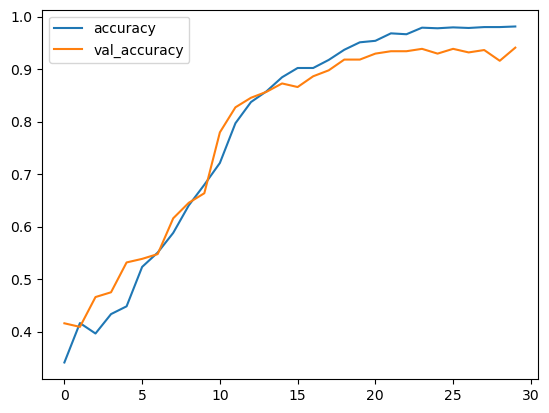

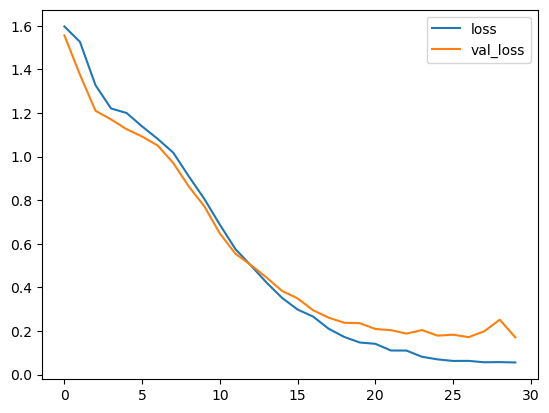

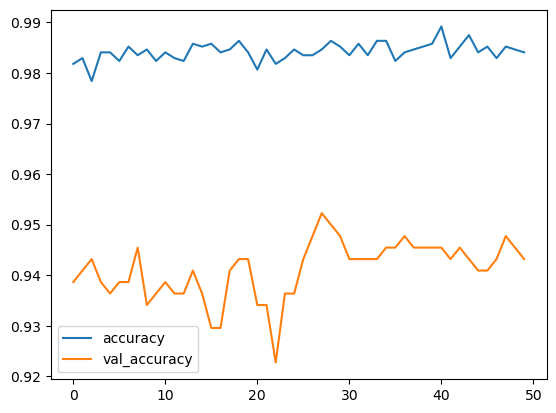

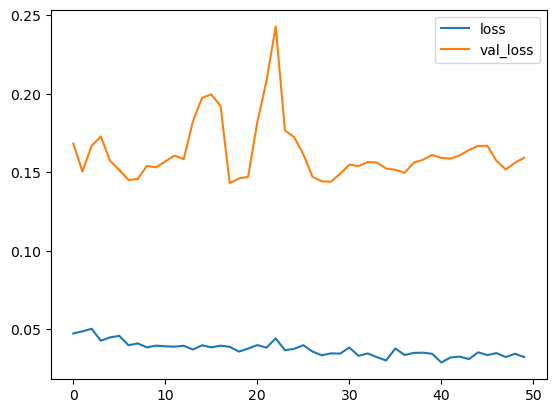

In [243]:
# Plot Training Results

history_df[['accuracy', 'val_accuracy']].plot()
history_df[['loss', 'val_loss']].plot()
history2_df[['accuracy', 'val_accuracy']].plot()
history2_df[['loss', 'val_loss']].plot()

In [263]:
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

14/14 [==============================] - 2s 126ms/step
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       180
           2       0.95      0.92      0.93       146
           3       0.90      0.94      0.92       102
           4       1.00      1.00      1.00        12

    accuracy                           0.94       440
   macro avg       0.95      0.96      0.95       440
weighted avg       0.94      0.94      0.94       440



# Model Saving

In [244]:
# Model Summary

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [245]:
# Freeze Model

model_lstm.trainable = False
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [246]:
# Save ANN Model

model_lstm.save('tweet_sentiment_model.h5')

# Model Inference

## Load Model

In [247]:
model_lstm = load_model('tweet_sentiment_model.h5')

## Inferencing

### Inference Data:

 74355. 9142,Nvidia,Negative,"It won't work, I've tried to repost it so many times"

 74332. 9138,Nvidia,Neutral,Mac is trash... they make things difficult to use nvidia graphic cards. Everything after I update my Mac I have to switch over my cards


 74322. 9136,Nvidia,Positive,"This is actually amazing. It's obviously not influenced by the hardware screen resolution but unless you use slightly differently to PC 2, you could test your VR resolution for free. Can't ask for more than that or free driver updates."

In [248]:
# Create A New Data

data_inf = {
    'tweet_content':"Mac is trash... they make things difficult to use nvidia graphic cards. Everything after I update my Mac I have to switch over my cards",
}

data_inf = pd.DataFrame([data_inf])
data_inf

,tweet_content
0,Mac is trash... they make things difficult to ...


In [249]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [250]:
X = data_inf['tweet_content'].apply(lambda p: clean_text(p))

In [251]:
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
english_stop_words = stopwords.words('english')

def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

In [252]:
reviewtweet = reviews(X)
no_stop_words_tweet = remove_stop_words(reviewtweet)
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

In [253]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)
X = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
X = pad_sequences(X, maxlen = 200)

In [254]:
y_pred_inf = model_lstm.predict(X)
y_pred_inf=np.argmax(y_pred_inf, axis=1)
y_pred_inf

1/1 [==============================] - 1s 577ms/step


array([3], dtype=int64)

# Conclusion

Model that created can determine the sentiment of tweets with 0.94 accuracy and 0.95 precision. Based on EDA, nvidia have more negative sentiment tweets although the difference is little which is 4%. NVIDIA must check on the negative tweets and fix the issue, but also need to check on positive tweets to maintain even to improve.